<a href="https://colab.research.google.com/github/alefram/notebooks/blob/master/pokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokedex using CNN

## Colab setup

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## Import Libraries

In [23]:
# import libraries

import os

os.environ["KERAS_BACKEND"] = "jax"
import keras
import jax

import PIL
import random
import pathlib
import datetime
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset

# Data Setup

In [2]:
#Download data
ds = load_dataset("fcakyon/pokemon-classification", name="full")

In [3]:
# Usefull methods

# visualize pokemons
def visualize_pokemons(images, labels, class_names):
    plt.figure(figsize=(10, 5))
    
    random_indices = np.random.choice(len(images), size=18, replace=False)

    for i, idx in enumerate(random_indices):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[idx].astype("uint8"))
        plt.title(class_names[labels[idx]])
        plt.axis("off")

In [4]:
ds = ds.with_format("jax")
train_ds = ds['train']
test_ds = ds['test']
val_ds =  ds['validation']
class_names = train_ds.features['labels'].names

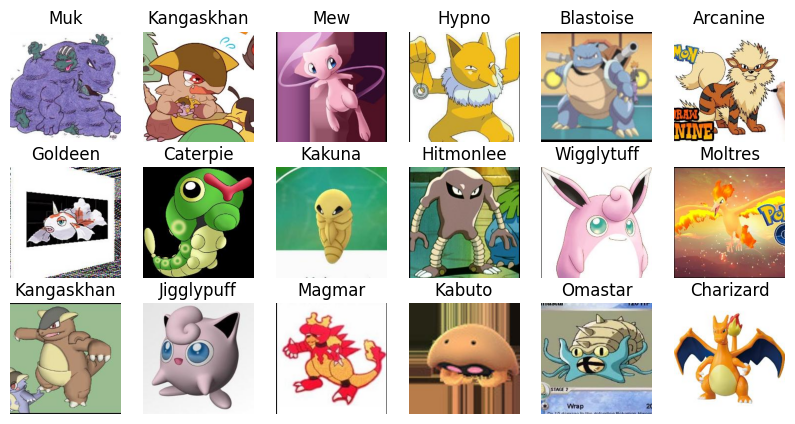

In [5]:
#visualize data
visualize_pokemons(
    images=train_ds['image'], 
    labels=train_ds['labels'], 
    class_names=class_names
) 

## Modeling




In [6]:
# Creating the model

#TODO optimizar
def create_pokedex_model(img_height, img_width, channels, num_classes):
    #input layer
    inputs = keras.layers.Input(shape=(img_height, img_width, channels))

    #TODO:mejorar las layers
    #blocks layers
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu")(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(64, kernel_size=5, activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    #flatten layer
    x = keras.layers.Flatten()(x)

    #output
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    #create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    #compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss="categorical_crossentropy",
                metrics=['accuracy'])

    return model


num_classes = len(class_names)
channels = 3
img_height = 224
img_width =224

model = create_pokedex_model(img_height, img_width, channels=3, num_classes=num_classes)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │    26,966,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,018,710 (103.07 MB)

 Trainable params: 27,018,710 (103.07 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [10]:
epochs = 1
batch_size = 32

train_labels = keras.utils.to_categorical(train_ds['labels'], num_classes=num_classes)
val_labels = keras.utils.to_categorical(val_ds['labels'], num_classes=num_classes)

# training
history = model.fit(
    x = train_ds['image'],
    y = train_labels,
    validation_data=(val_ds['image'], val_labels),
    epochs=epochs,
    batch_size=batch_size,
)

153/153 ━━━━━━━━━━━━━━━━━━━━ 1199s 8s/step - accuracy: 0.0083 - loss: 15.9751 - val_accuracy: 0.0000e+00 - val_loss: 16.1181


# Evaluation

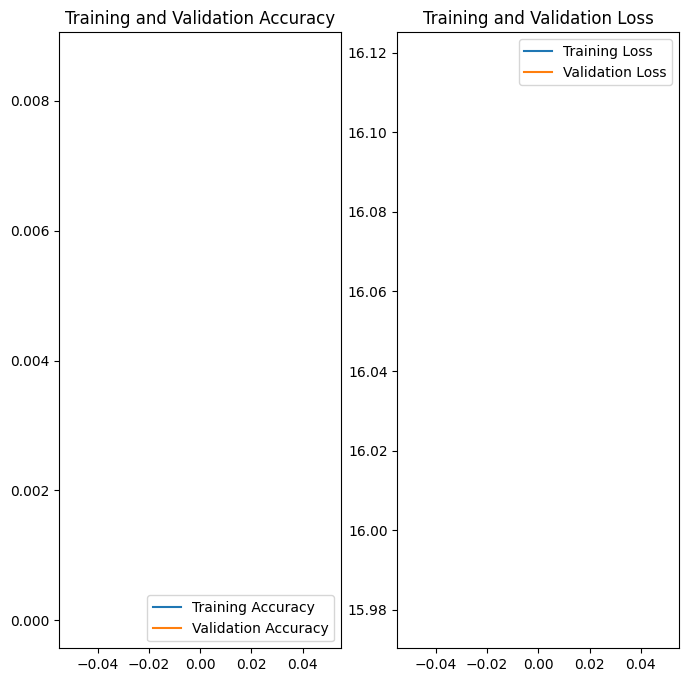

In [11]:
# Evaluate model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

pokemon name:  Poliwrath label:  50


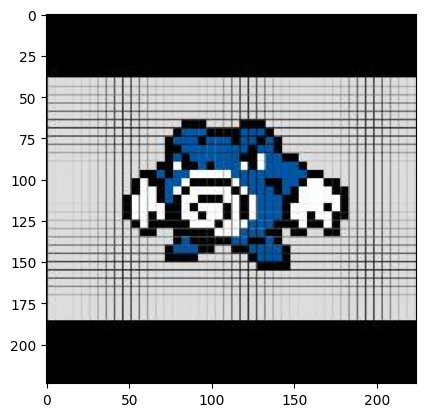

In [17]:
n = 
image = test_ds['image'][n]
label =  test_ds['labels'][n]
print("pokemon name: ", class_names[label], "label: ", label)

plt.imshow(image.astype("uint8"))

In [27]:
#TODO: actualizar testing
img_array = keras.utils.img_to_array(test_ds['image'][n])
img_array = jax.numpy.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array) ## it is for large predict batches

predictions = model(img_array, training=False)
score = keras.layers.Softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

TypeError: unsupported operand type(s) for *: 'int' and 'Softmax'